In [996]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_csv("signal.csv")
bkgnd = pd.read_csv("background.csv")
test_data = pd.read_csv("Test.csv")

In [997]:
test_data = test_data.drop(['Z_m', 'dimuon_m'], axis=1)

In [998]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311198 entries, 0 to 311197
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   dilepton_m          311198 non-null  float64
 1   leading_lepton_pt   311198 non-null  float64
 2   trailing_lepton_pt  311198 non-null  float64
 3   leading_muon_pt     311198 non-null  float64
 4   trailing_muon_pt    311198 non-null  float64
 5   dimuon_pt           311198 non-null  float64
 6   rIsoOverPtl1        311198 non-null  float64
 7   rIsoOverPtl2        311198 non-null  float64
 8   rIsoOverPtm1        311198 non-null  float64
 9   rIsoOverPtm2        311198 non-null  float64
 10  ipSm1               311198 non-null  float64
 11  ipSm2               311198 non-null  float64
dtypes: float64(12)
memory usage: 28.5 MB


In [999]:
signal['signal/bkgnd'] = 1
bkgnd['signal/bkgnd'] = 0

In [1000]:
signal = signal.drop(['Z_m', 'dimuon_m'], axis=1)
bkgnd = bkgnd.drop(['Z_m', 'dimuon_m'], axis=1)

In [1001]:
df = pd.concat([signal,bkgnd])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143823 entries, 0 to 133080
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   dilepton_m          143823 non-null  float64
 1   leading_lepton_pt   143823 non-null  float64
 2   trailing_lepton_pt  143823 non-null  float64
 3   leading_muon_pt     143823 non-null  float64
 4   trailing_muon_pt    143823 non-null  float64
 5   dimuon_pt           143823 non-null  float64
 6   rIsoOverPtl1        143823 non-null  float64
 7   rIsoOverPtl2        143823 non-null  float64
 8   rIsoOverPtm1        143823 non-null  float64
 9   rIsoOverPtm2        143823 non-null  float64
 10  ipSm1               143823 non-null  float64
 11  ipSm2               143823 non-null  float64
 12  signal/bkgnd        143823 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 15.4 MB


In [1002]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
train_y = df['signal/bkgnd'] #label = signal/bkgnd

In [1003]:
#SIGNAL
signal_x = signal.drop(['signal/bkgnd'], axis=1)
signal_y = signal['signal/bkgnd']

In [1004]:
#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [1005]:
#SAMPLING DATA
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.3, 
                                                  random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.3, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.3, 
                                                  random_state=1)

In [1006]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', 
                          max_depth = 3, 
                          learning_rate=0.028 
                          #gamma=10, 
                          #min_child_weight=5
                         )
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.028, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1007]:
predict_signal = model.predict(test_signal_x)
print(np.round(accuracy_score(test_signal_y,predict_signal)*100, 2),'%')

86.57 %


In [1055]:
predict_prob = model.predict_proba(test_signal_x)
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_signal = df_prob[df_prob.columns[1]] 
list_prob_signal = s_prob_signal.values.tolist()
df_prob.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223 entries, 0 to 3222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3223 non-null   float32
 1   1       3223 non-null   float32
dtypes: float32(2)
memory usage: 25.3 KB


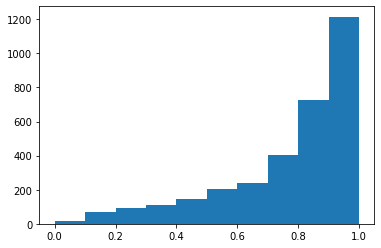

In [1009]:
hist_signal = plt.hist(list_prob_signal, range=(0,1))

In [1010]:
predict_prob_bkgnd = model.predict_proba(test_bkgnd_x)
df_prob_bkgnd = pd.DataFrame(predict_prob_bkgnd)
s_prob_bkgnd = df_prob_bkgnd[df_prob_bkgnd.columns[1]] 
list_prob_bkgnd = s_prob_bkgnd.values.tolist()

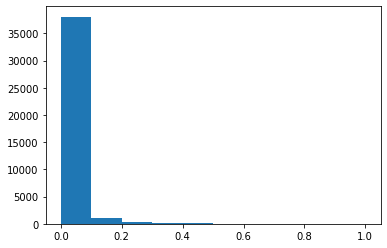

In [1011]:
hist_bkgnd = plt.hist(list_prob_bkgnd, range=(0,1))

Text(0.5, 1.0, 'Signal vs Bkgnd (XGB)')

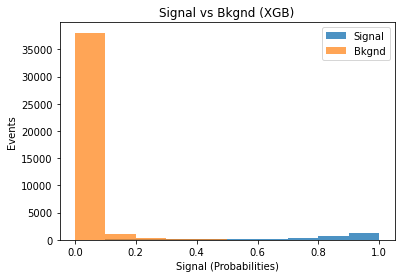

In [1012]:
plt.hist(list_prob_signal, range=(0,1), alpha=0.8,label='Signal')
plt.hist(list_prob_bkgnd, range=(0,1), alpha=0.7, label='Bkgnd')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')
plt.title('Signal vs Bkgnd (XGB)')

ROC AUC=  0.9971849040010481


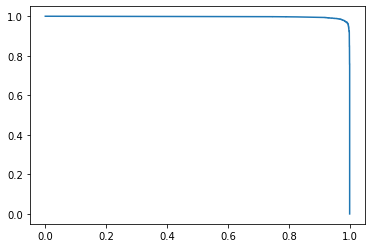

In [1013]:
model_predict1 = model.predict_proba(test_x)
model_predict1 = model_predict1[:,1]
auc_score1 = roc_auc_score(test_y, model_predict1)
fpr1, tpr1, _ = roc_curve(test_y, model_predict1)
testp = plt.plot(tpr1, 1-fpr1, label='test')
print('ROC AUC= ', auc_score1)
plt.show()

ROC AUC=  0.9973426763828337


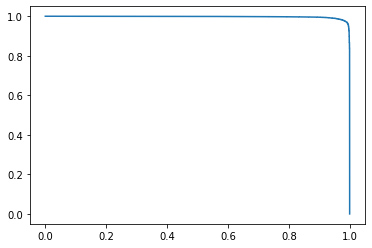

In [1014]:
model_predict2 = model.predict_proba(train_x)
model_predict2 = model_predict2[:,1]
auc_score = roc_auc_score(train_y, model_predict2)
fpr2, tpr2, _ = roc_curve(train_y, model_predict2)
trainp = plt.plot(tpr2, 1-fpr2, label='train')
print('ROC AUC= ', auc_score)
plt.show()

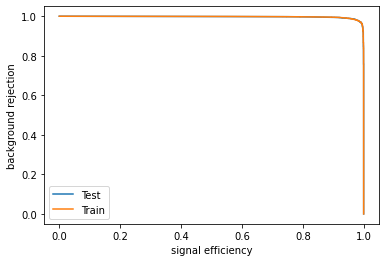

In [1015]:
plt.plot(tpr1, 1-fpr1, label='Test')
plt.plot(tpr2, 1-fpr2, label='Train')
plt.legend(loc='lower left')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.show()

In [1044]:
test_prob = model.predict_proba(test_data)
#converting prob values to list
df_test = pd.DataFrame(test_prob)
df_test_signal= df_test[df_test.columns[1]]
list_test_signal = df_test_signal.values.tolist()

In [1050]:
signal_val = []
for i in list_test_signal:
    if(i >=0.5):
        signal_val.append(i)
#df_test_50 = df_test[df_test.signal >= 0.5]

In [1054]:
len(signal_val)

3063

Text(0, 0.5, 'Events')

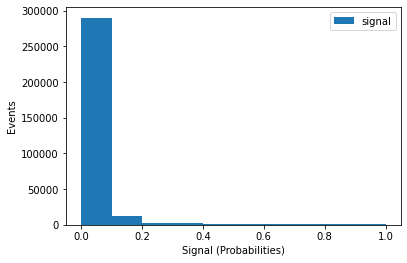

In [1038]:
test_hist_signal = plt.hist(list_test_signal, range=(0,1), label='signal')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')

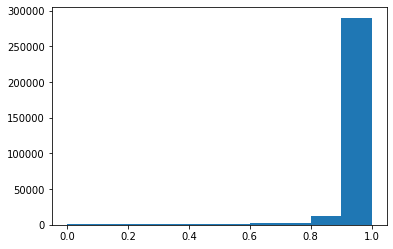

In [1028]:
df_test_bkgnd= df_test[df_test.columns[0]]
list_test_bkgnd = df_test_bkgnd.values.tolist()
test_hist_bkgnd = plt.hist(list_test_bkgnd, range=(0,1))

In [1057]:
bkgnd_val = []
for j in list_test_bkgnd:
    if(j >=0.5):
        bkgnd_val.append(j)
len(bkgnd_val)

308135